## 📦 **Import Libraries**

In [1]:
!pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 11.6 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings('ignore')

# mount drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import re, string

import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from wordcloud import WordCloud

# from googletrans import Translator
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

Mounted at /content/drive


## 🗃️ **Data Preparation**

In [3]:
dir = '/content/drive/MyDrive/Colab Notebooks/ml-stuff/data/'

services = pd.read_csv(dir + 'services_preprocessed_re.csv')
projects = pd.read_csv(dir + 'projects_preprocessed_minimum.csv')

kamus_alay = pd.read_csv('https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv')
# kamus_alay = pd.read_csv(dir + 'colloquial-indonesian-lexicon.csv')
kamus_alay = kamus_alay.filter(['slang', 'formal'], axis = 1).drop_duplicates(subset = ['slang'])
kamus_alay_map = dict(zip(kamus_alay['slang'], kamus_alay['formal']))

#### 📂 **Dataset Information**

In [4]:
projects.head(2)

,Unnamed: 0,text_clean,finishDays,tags_token,budget
0,0,penulis yang tinggal di apartemen jakarta menu...,7.0,['Writing'],250000.0
1,1,membuat artikel di media online pekerjaan memb...,7.0,"['Blog', 'Blogspot', 'Content Management Syste...",350000.0


In [5]:
services.head(2)

,Unnamed: 0,text_clean,workDuration,tags_token,fixedFee
0,0,saya bisa membuat sistem dan tampilan website ...,30.0,"['Web Programming', 'PHP', 'Website', 'Wordpre...",650000
1,1,kesusahan slicing design mobile apps atau meng...,3.0,"['Java', 'Mobile Programming', 'Windows Mobile...",200000


## 📊 **Exploratory Data Analysis**

### **Missing Values Overview**

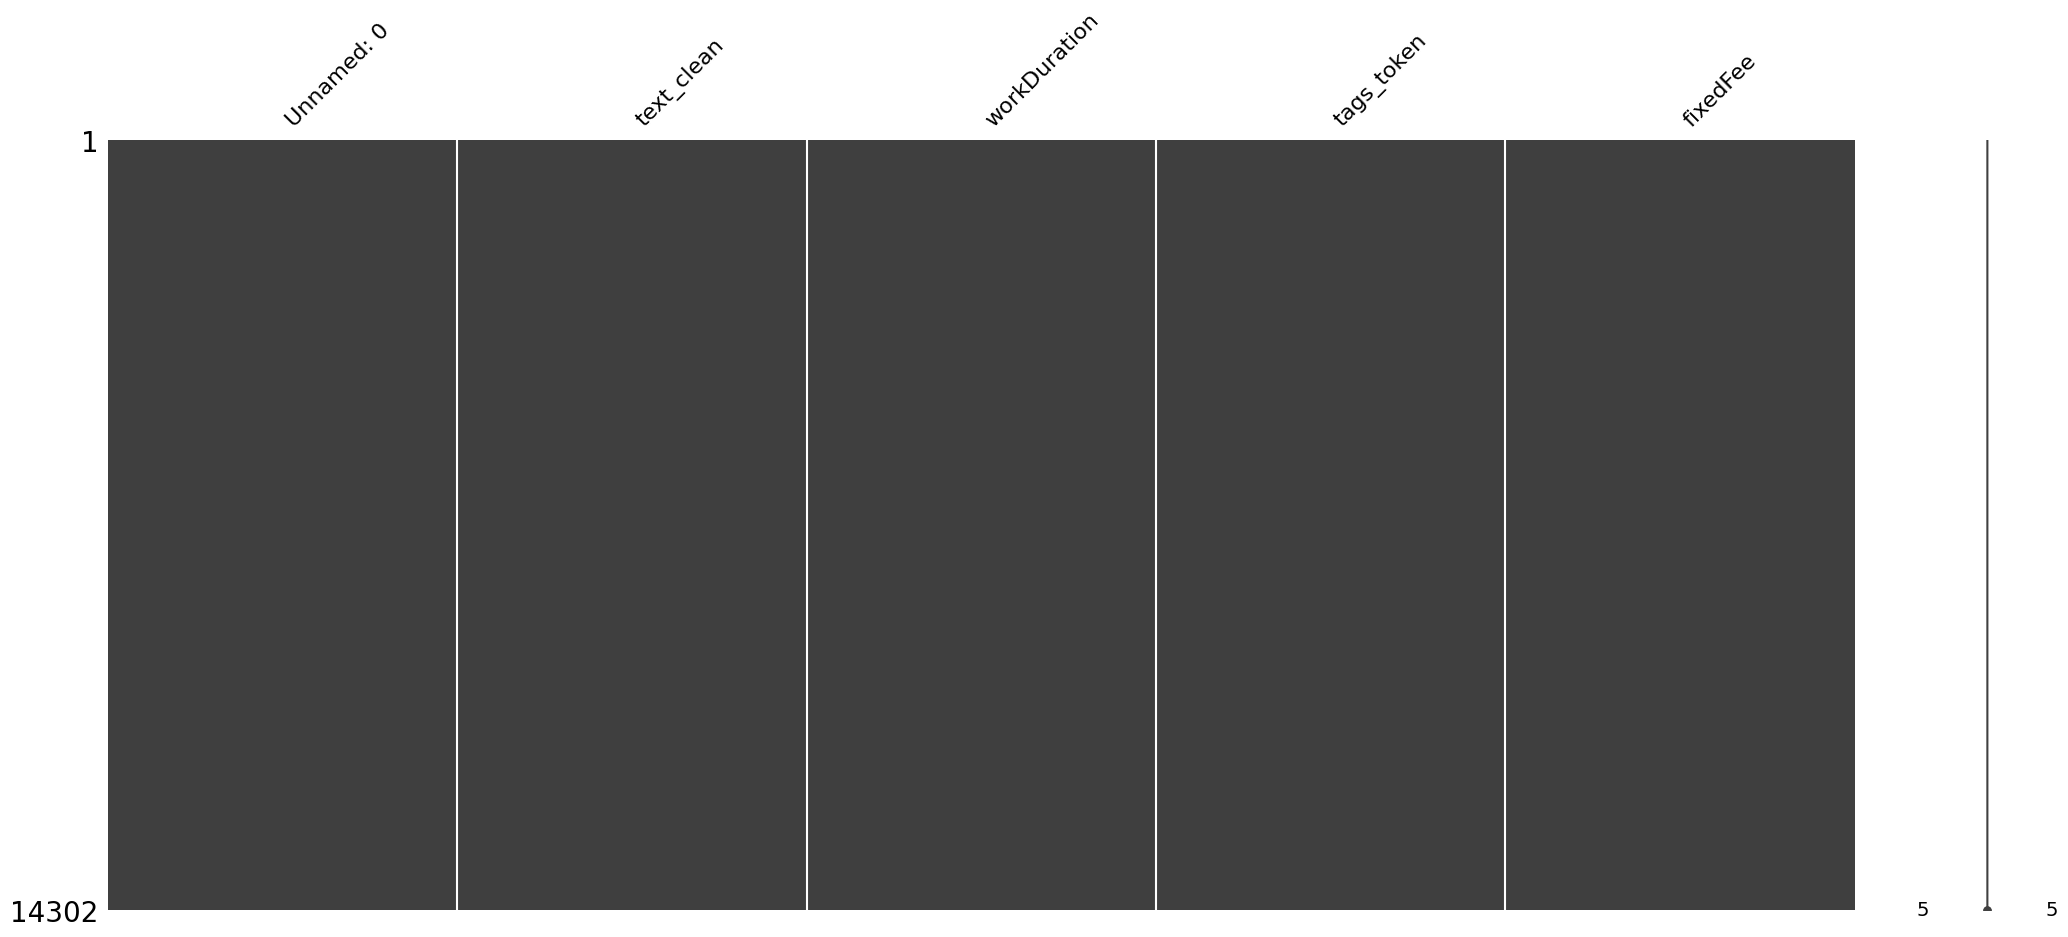

In [6]:
msno.matrix(services)
plt.show()

In [7]:
round(services.isna().mean().sort_values(ascending = False), 4)

Unnamed: 0      0.0
text_clean      0.0
workDuration    0.0
tags_token      0.0
fixedFee        0.0
dtype: float64

In [8]:
df_services = services
df_projects = projects

In [9]:
df_services.head(2)

,Unnamed: 0,text_clean,workDuration,tags_token,fixedFee
0,0,saya bisa membuat sistem dan tampilan website ...,30.0,"['Web Programming', 'PHP', 'Website', 'Wordpre...",650000
1,1,kesusahan slicing design mobile apps atau meng...,3.0,"['Java', 'Mobile Programming', 'Windows Mobile...",200000


In [10]:
df_projects.head(2)

,Unnamed: 0,text_clean,finishDays,tags_token,budget
0,0,penulis yang tinggal di apartemen jakarta menu...,7.0,['Writing'],250000.0
1,1,membuat artikel di media online pekerjaan memb...,7.0,"['Blog', 'Blogspot', 'Content Management Syste...",350000.0


In [11]:
df_services.rename(columns = {'tags_token':'service_tags'}, inplace = True)
df_services.rename(columns = {'text_clean':'text'}, inplace = True)
df_services.drop('Unnamed: 0', axis = 1, inplace = True)

In [12]:
df_projects.rename(columns = {'tags_token':'projects_tags'}, inplace = True)
df_projects.rename(columns = {'text_clean':'text'}, inplace = True)
df_projects.drop('Unnamed: 0', axis = 1, inplace = True)

##`project_tags`

In [13]:
# Filtering the rare terms.
df_services = df_services.groupby("service_tags").filter(lambda x: len(x) > 1)
df_services['service_tags']

2        ['Advertising', 'Design Arts', 'Brochure', 'Gr...
5                     ['Search Engine Optimization (SEO)']
6                                              ['Youtube']
13                    ['Search Engine Optimization (SEO)']
16                                             ['Website']
                               ...                        
14291                    ['Advertising', 'Google Adwords']
14292                                          ['Android']
14293                                       ['Copywriter']
14297    ['Website', 'Wordpress', 'Web Design', 'Websit...
14300                           ['Translation', 'Writing']
Name: service_tags, Length: 6947, dtype: object

In [14]:
# Filtering the rare terms.
df_projects = df_projects.groupby("projects_tags").filter(lambda x: len(x) > 1)
df_projects['projects_tags']

0                                              ['Writing']
3        ['Design Arts', 'Graphic Design', 'Logo Design...
4                                           ['iPhone/iOS']
5                                              ['Writing']
6                 ['Data Entry', 'Quesioner', 'Responden']
                               ...                        
39221                                  ['Email Marketing']
39222                                          ['English']
39224                                   ['Graphic Design']
39225                                  ['Adobe PhotoShop']
39226                     ['CorelDRAW', 'Adobe PhotoShop']
Name: projects_tags, Length: 27838, dtype: object

In [15]:
import ast 

df_services['service_tags'] = [ast.literal_eval(i) for i in df_services['service_tags']]
df_services['service_tags'].values[:5]

array([list(['Advertising', 'Design Arts', 'Brochure', 'Graphic Design', 'Logo Design', 'Adobe PhotoShop', 'Adobe Illustrator', 'Multimedia', 'PIC', 'Instagram', 'Infogram']),
       list(['Search Engine Optimization (SEO)']), list(['Youtube']),
       list(['Search Engine Optimization (SEO)']), list(['Website'])],
      dtype=object)

In [16]:
import ast 

df_projects['projects_tags'] = [ast.literal_eval(i) for i in df_projects['projects_tags']]
df_projects['projects_tags'].values[:5]

array([list(['Writing']),
       list(['Design Arts', 'Graphic Design', 'Logo Design', 'Canva']),
       list(['iPhone/iOS']), list(['Writing']),
       list(['Data Entry', 'Quesioner', 'Responden'])], dtype=object)

In [17]:
df_services['text'] = df_services['text'].astype(str)
df_projects['text'] = df_projects['text'].astype(str)

## Base Model

In [18]:
from sklearn.model_selection import train_test_split

test_split = 0.1

# Initial train and test split.
projects_train_df, projects_test_df = train_test_split(
    df_projects,
    test_size=test_split,
    stratify=df_projects["projects_tags"].values,
)

# Splitting the test set further into validation
# and new test sets.
projects_val_df = projects_test_df.sample(frac=0.5)
projects_test_df.drop(projects_val_df.index, inplace=True)

print(f"Number of rows in training set: {len(projects_train_df)}")
print(f"Number of rows in validation set: {len(projects_val_df)}")
print(f"Number of rows in test set: {len(projects_test_df)}")

Number of rows in training set: 25054
Number of rows in validation set: 1392
Number of rows in test set: 1392


In [19]:
from sklearn.model_selection import train_test_split

test_split = 0.2

# Initial train and test split.
services_train_df, services_test_df = train_test_split(
    df_services,
    test_size=test_split,
    stratify=df_services["service_tags"].values,
)

# Splitting the test set further into validation
# and new test sets.
services_val_df = services_test_df.sample(frac=0.5)
services_test_df.drop(services_val_df.index, inplace=True)

print(f"Number of rows in training set: {len(services_train_df)}")
print(f"Number of rows in validation set: {len(services_val_df)}")
print(f"Number of rows in test set: {len(services_test_df)}")

Number of rows in training set: 5557
Number of rows in validation set: 695
Number of rows in test set: 695


In [20]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

In [21]:
terms = tf.ragged.constant(projects_train_df["projects_tags"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', 'Writing', 'PHP', 'Content Writer', 'Copywriter', 'Wordpress', 'Adobe PhotoShop', 'Data Entry', 'Search Engine Optimization (SEO)', 'Blog', 'Graphic Design', 'MySQL', 'Web Programming', 'Website', 'CodeIgniter', 'CorelDRAW', 'Android', 'Adobe Illustrator', 'Microsoft Word', 'HTML', 'Wordpress Templates', 'Laravel Framework', 'Logo Design', 'Web Design', 'CSS', 'Android studio', 'Internet Marketing', 'JavaScript', 'Website Building', 'Blogspot', 'Mobile Programming', 'Website Templates', 'Social Media Marketing (SMM)', 'English', 'Microsoft Excel', 'Video Editing', 'Video Production', 'Design Arts', 'Translation', 'Bootstrap', 'Market Research', 'Python', 'Web Research', 'Java', 'Web Scrapping', 'Instagram', 'Screenwriting', 'jQuery', 'Administration', 'Adobe Indesign', 'WooCommerce', 'Data Mining', 'Corel PhotoPaint', 'Facebook', 'E-Commerce', 'Data Analysis', 'Adobe Premiere', 'Adobe After Effects', 'Youtube', 'CSS Templates', 'Microsoft Office', 'Database Progr

In [22]:
sample_label = projects_train_df["projects_tags"].iloc[250]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['MySQL', 'PHP']
Label-binarized representation: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [23]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["projects_tags"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["text"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [24]:
services_val_df.rename(columns = {'service_tags':'projects_tags'}, inplace = True)
services_test_df.rename(columns = {'service_tags':'projects_tags'}, inplace = True)

In [25]:
train_dataset = make_dataset(projects_train_df, is_train=True)
validation_dataset = make_dataset(services_val_df, is_train=False)
test_dataset = make_dataset(services_test_df, is_train=False)

In [26]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Text: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Text: b'design logo dan packaging makanan anjing nama merk woofie dog food woofie dog food adalah merk makanan hewan terutama anjing yang terbuat dari daging segar tanpa bahan pengawet atau campuran bahan kimia referensi design bisa mengacu pada kin dog food dan escobark id'
Label(s): ['Logo Design']
 
Text: b'melengkapi program android saya mempunyai project android yang terhubung dengan database dari hosting dan api php untuk menghubungkan nya sudah ada dan saya ingin melengkapi transaksi penjualan yang belum selesai dan sedikit menambah template untuk tampilan badget saya dikit hanya sekitar 500 ribu'
Label(s): ['PHP' 'MySQL' 'Android' 'Android studio']
 
Text: b'menulis 10 artikel bertema sosial media marketing saya membutuhkan seseorang menulis artikel dengan tema sosial media merketing dengan ketentuan umum sebagai berikut berpengalaman menulis artikel seo langsung posting di blog mengandung minimal 700 kata artikel benar benar baru bukan kopas menggunakan kata kunci yang diberik

In [27]:
vocabulary = set()
projects_train_df["text"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

38681


In [28]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

In [29]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [   layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model

In [30]:
epochs = 20

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)

Epoch 1/20
196/196 [==============================] - 12s 24ms/step - loss: 0.0472 - binary_accuracy: 0.9862 - val_loss: 0.0402 - val_binary_accuracy: 0.9921
Epoch 2/20
196/196 [==============================] - 4s 19ms/step - loss: 0.0100 - binary_accuracy: 0.9969 - val_loss: 0.0370 - val_binary_accuracy: 0.9921
Epoch 3/20
196/196 [==============================] - 5s 23ms/step - loss: 0.0047 - binary_accuracy: 0.9986 - val_loss: 0.0404 - val_binary_accuracy: 0.9920
Epoch 4/20
196/196 [==============================] - 4s 21ms/step - loss: 0.0030 - binary_accuracy: 0.9993 - val_loss: 0.0451 - val_binary_accuracy: 0.9920
Epoch 5/20
196/196 [==============================] - 4s 19ms/step - loss: 0.0023 - binary_accuracy: 0.9995 - val_loss: 0.0484 - val_binary_accuracy: 0.9918
Epoch 6/20
196/196 [==============================] - 4s 20ms/step - loss: 0.0019 - binary_accuracy: 0.9996 - val_loss: 0.0504 - val_binary_accuracy: 0.9919
Epoch 7/20
196/196 [==============================] - 4s 

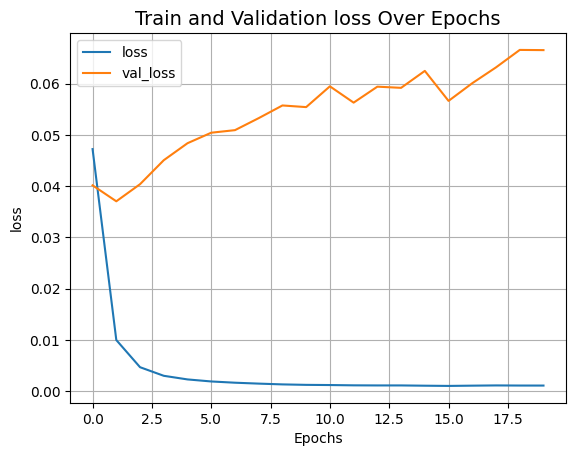

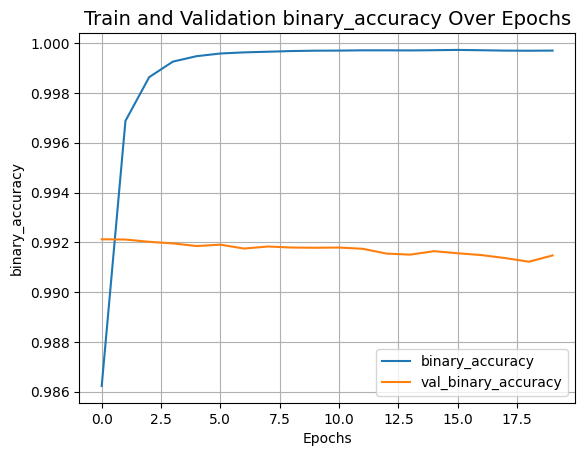

In [31]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")

In [32]:
_, binary_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(binary_acc * 100, 2)}%.")

6/6 [==============================] - 0s 12ms/step - loss: 0.0605 - binary_accuracy: 0.9917
Categorical accuracy on the test set: 99.17%.


## Saving Model

In [38]:
path = '/content/drive/MyDrive/Colab Notebooks/ml-stuff/model/projects/'

In [39]:
!mkdir -p saved_model
shallow_mlp_model.save(path + 'owner/browse_service_model/my_model')

## Load Model

In [40]:
browse_service_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/ml-stuff/model/projects/owner/browse_service_model/my_model')

## Prediction

In [42]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, browse_service_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(projects_test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Text: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_5_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:5]
    print(f"Predicted Label(s): ({', '.join([label for label in top_5_labels])})")
    print(" ")

4/4 [==============================] - 0s 11ms/step
Text: b'website pendaftaran halo worker detail project terlampir ketentuan source code akan menjadi hak owner mohon meninggalkan no hp yang terintegrasi dengan wa chat dan pertanyaan akan direspons apabila memenuhi syarat nomer 2'
Label(s): ['Web Programming' 'Website' 'Web Design' 'Website Building']
Predicted Label(s): (Website Building, PHP, Laravel Framework, Web Design, Web Programming)
 
Text: b'menulis deskripsi suatu software butuh banyak penulis saat ini saya membutuhkan banyak penulis projectnya cukup mudah yakni hanya menulis deskripsi suatu software aplikasi semisaldeskripsi software mozilla firefox pada project kemarin saya mendapatkan 5 penulis namun 2 diantaranya saya arbritase karena tidak mengumpulkan artikel sesuai deadline telat dari deadline jadi pastikan anda nanti mengumpulkan project sesuai deadline yang diberikan jika diterima dalam project ini anda bisa melihat sampel artikelnya melalui link dibawah'
Label(s):